<a href="https://colab.research.google.com/github/injoon-pij/dlnlp-learning/blob/main/dlnlp_cnn(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Convolution Neural Network

https://github.com/injoon-pij/pytorch-learning/blob/master/pytorch_cnn.ipynb

위 링크의 __1) What is CNN : Convolution and Pooling__ 참고

# 2) 1D CNN for NLP

* LSTM 실습에서 각 문장이 임베딩 층을 지나 각 단어가 임베딩 벡터된 상태로 LSTM 층에 입력되었던 것과 마찬가지로, 1D CNN 층 역시 각 단어가 임베딩 벡터로 변환된 문장 행렬이 입력됨

* 'wait for the video and don't rent it'이라는 문장이 있고 이 문장이 토큰화, 패딩, 임베딩 층을 거친다면 아래 같은 형태의 행렬로 변환될 것임

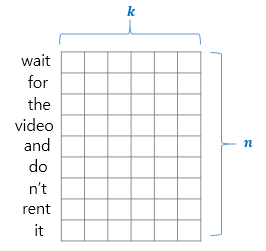

__[1D CNN에서 문장 행렬을 처리하는 과정 (커널 사이즈 : (2,))]__

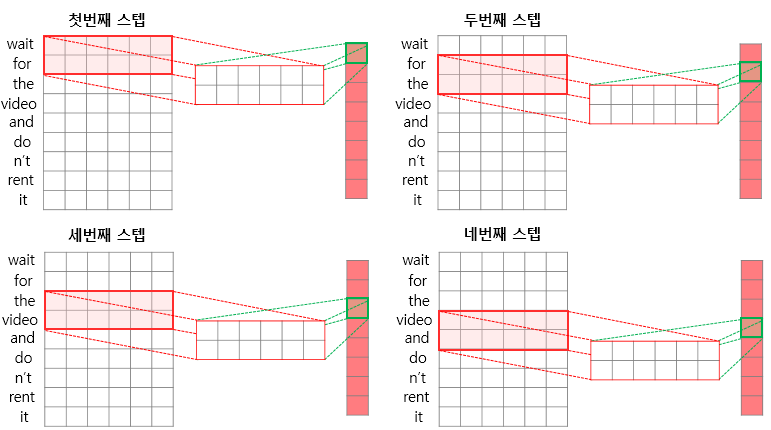

* 1D CNN에서 커널의 너비는 문장 행렬에서의 임베딩 벡터의 차원과 자동으로 동일하게 설정됨
* 따라서 1D CNN에서는 높이 사이즈만을 명명하여 이를 해당 커널의 사이즈로 선언함
 * 커널의 너비가 임베딩 벡터의 차원이라는 의미는 커널이 2D CNN때와는 달리 너비 방향으로는 더 이상 움직일 곳이 없다는 것이므로 1D CNN에서는 커널이 문장 행렬의 높이 방향으로만 움직이게 되어있음
 * 즉, 위 그림에서 커널은 2D CNN때와는 달리 오른쪽으로는 움직일 공간이 없으므로 아래쪽으로만 이동해야 함
* 예를 들어 커널의 사이즈가 2인 경우, 위의 그림과 같이 높이가 2, 너비가 임베딩 벡터의 차원인 커널이 사용되고 문장 행렬 아래쪽으로 스텝을 이동하며 연산을 진행함


__[1D CNN에서 문장 행렬을 처리하는 과정 (커널 사이즈 : (3,))]__

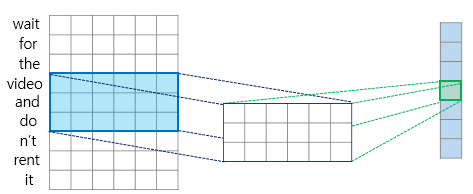

* CNN에서의 커널은 신경망 관점에서는 가중치 행렬이므로 커널의 사이즈에 따라 학습하게 되는 파라미터의 수가 달라짐
* 1D CNN과 자연어 처리 관점에서는 커널의 사이즈에 따라서 참고하는 단어의 묶음(n-gram)의 크기가 달라짐
 * 가령, 커널의 사이즈가 2라면 각 연산의 스텝에서 참고하는 것은 bigram, 커널의 사이즈가 3이라면 각 연산의 스텝에서 참고하는 것은 trigramdla

__[Max Pooling]__

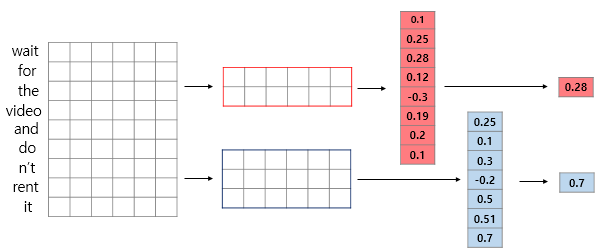

* 일반적으로 1D CNN에서도 2D CNN에서와 마찬가지로 합성곱 층(합성곱 연산 + 활성화 함수) 다음에는 풀링 층을 추가하게 됨
* 풀링층에서 대표적으로 사용되는 것이 맥스 풀링
 * 각 합성곱 연산으로부터 얻은 결과 벡터에서 가장 큰 값을 가진 스칼라 값을 빼내는 연산입
* 예를 들어 위의 그림은 사이즈가 2인 커널과 사이즈가 3인 커널 두 개의 커널로부터 각각 결과 벡터를 얻고, 각 벡터에서 가장 큰 값을 꺼내오는 맥스 풀링 연산을 수행한 것

__[Modeling CNN]__ 

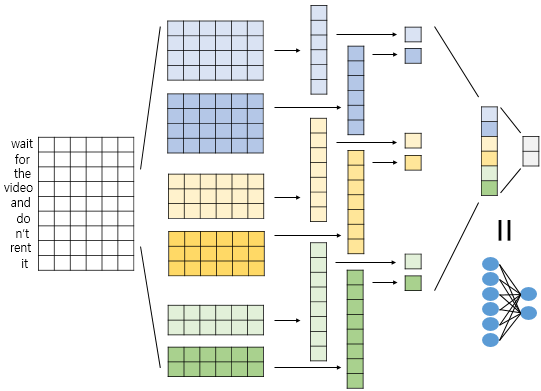

* kernel
 * kernel_size = (4,) : 2개
 * kernel_size = (3,) : 2개
 * kernel_size = (2,) : 2개

* 합성곱 연산과 맥스 풀링을 수행하여 나온 6개의 스칼라값을 일반적으로 전부 연결(concatenate)하여 하나의 벡터로 만들어줌
 * 이렇게 얻은 벡터는 곧 1D CNN을 통해 얻은 입력 문장의 최종 특성 벡터가 되어 출력층에 입력됨

# 3) Text classification by 1D CNN (IMDB)

## 3.1 Data preprocessing

In [1]:
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
vocab_size = 10000
(X_train, y_train), (X_test, y_test) = datasets.imdb.load_data(num_words = vocab_size)

17473536/17464789 [==============================] - 1s 0us/step


* 각 샘플은 이미 정수 인코딩까지 전처리가 된 상태임

In [3]:
max_len = 200
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [4]:
print('X_train의 크기(shape) :',X_train.shape)
print('X_test의 크기(shape) :',X_test.shape)

X_train의 크기(shape) : (25000, 200)
X_test의 크기(shape) : (25000, 200)


In [5]:
print(y_train[:5])

[1 0 0 1 0]


## 3.2 Modeling

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [7]:
embedding_dim = 256
dropout_ratio = 0.3
num_filters = 256
kernel_size = 3
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(dropout_ratio))
model.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_units, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(1, activation='sigmoid'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         2560000   
_________________________________________________________________
dropout (Dropout)            (None, None, 256)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 256)         196864    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

* conv1d layer
 * output_shape : ```(None, None, 256)```
   * filter의 개수가 256개이므로
   * 필터의 개수에 따라 출력 공간의 차원이 변경됨
 * parameters : 196864
   * 256(embedding dim) * 3(kernel_size) * 256(num_filters) = 196608 
   * 1(bias) * 256(num_filters) = 256

In [9]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

In [10]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['acc'])
history = model.fit(X_train, y_train, epochs = 20, validation_data = (X_test, y_test), callbacks=[es, mc])

Epoch 1/20
782/782 [==============================] - 205s 260ms/step - loss: 0.4006 - acc: 0.8083 - val_loss: 0.2877 - val_acc: 0.8760

Epoch 00001: val_acc improved from -inf to 0.87604, saving model to best_model.h5
Epoch 2/20
782/782 [==============================] - 200s 256ms/step - loss: 0.2078 - acc: 0.9172 - val_loss: 0.2622 - val_acc: 0.8906

Epoch 00002: val_acc improved from 0.87604 to 0.89060, saving model to best_model.h5
Epoch 3/20
782/782 [==============================] - 199s 255ms/step - loss: 0.0964 - acc: 0.9673 - val_loss: 0.3031 - val_acc: 0.8888

Epoch 00003: val_acc did not improve from 0.89060
Epoch 4/20
782/782 [==============================] - 200s 255ms/step - loss: 0.0375 - acc: 0.9873 - val_loss: 0.4082 - val_acc: 0.8833

Epoch 00004: val_acc did not improve from 0.89060
Epoch 5/20
782/782 [==============================] - 197s 252ms/step - loss: 0.0243 - acc: 0.9920 - val_loss: 0.5107 - val_acc: 0.8799

Epoch 00005: val_acc did not improve from 0.8906

In [11]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

782/782 [==============================] - 37s 47ms/step - loss: 0.2622 - acc: 0.8906

 테스트 정확도: 0.8906


# 4) Text classification by 1D CNN (Spam Detection)

## 4.1 Data preprocessing

https://github.com/injoon-pij/dlnlp-learning/blob/main/dlnlp_text_classification_by_rnn(English).ipynb

아래의 데이터 전처리 과정에 대한 자세한 설명은 위 링크의 __1) Spam Detection__ 와 동일하므로 참고

In [ ]:
import numpy as np
import pandas as pd
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv", filename="spam.csv")
data = pd.read_csv('spam.csv',encoding='latin1')

# 불필요한 열 삭제
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']

# ham과 spam 레이블을 각각 숫자 0과 1로 변경
data['v1'] = data['v1'].replace(['ham','spam'],[0,1])

# v2 열에서 중복 데이터 제거
data.drop_duplicates(subset=['v2'], inplace=True)

# X,y data
X_data = data['v2']
y_data = data['v1']

# 단어 토큰화 및 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data)
sequences = tokenizer.texts_to_sequences(X_data)
word_to_index = tokenizer.word_index

# 패딩토큰 (0번 인덱스) 고려하여 +1
vocab_size = len(word_to_index) + 1

# 전체 데이터셋을 max_len으로 패딩
X_data = sequences
max_len = 189
data = pad_sequences(X_data, maxlen = max_len)

# train-test data split
n_of_train = int(len(sequences) * 0.8)
n_of_test = int(len(sequences) - n_of_train)
X_test = data[n_of_train:]
y_test = np.array(y_data[n_of_train:])
X_train = data[:n_of_train]
y_train = np.array(y_data[:n_of_train])

## 4.2 Modeling

In [ ]:
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, Dropout, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
embedding_dim = 32
dropout_ratio = 0.3
num_filters = 32
kernel_size = 5

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(dropout_ratio))
model.add(Conv1D(num_filters, kernel_size, strides=1, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(dropout_ratio))
model.add(Dense(1, activation='sigmoid'))

* ```Conv1D(filters = num_filters, ..., padding='valid')```
 * ```filters=``` : how many different windows you will have (= How many different results or channels you want to produce)
   * When you use ```filters=100``` and ```kernel_size=4```, you are creating 100 different filters, each of them with length 4. The result will bring 100 different convolutions.

 * ```padding=```
   * ```valid```: 패딩 없음
   * ```same``` : 아웃풋이 원래 인풋과 동일한 길이를 갖도록 인풋을 패딩
   * ```causal``` : 아웃풋이 원래 인풋과 동일한 길이를 갖도록 아웃풋을 제로패딩

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          285472    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 290,657
Trainable params: 290,657
Non-trainable params: 0
________________________________________________

* conv1d layer
 * output_shape : ```(None, None, 32)```
   * filter의 개수가 32개이므로
   * 필터의 개수에 따라 출력 공간의 차원이 변경됨
 * parameters : 5152
   * 32(embedding dim) * 5(kernel_size) * 32(num_filters) = 5120 
   * 1(bias) * 32(num_filters) = 32

In [ ]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs = 10, batch_size=64, validation_split=0.2, callbacks=[es, mc])

Epoch 1/10
52/52 [==============================] - 3s 33ms/step - loss: 0.4596 - acc: 0.8673 - val_loss: 0.3819 - val_acc: 0.8730

Epoch 00001: val_acc improved from -inf to 0.87304, saving model to best_model.h5
Epoch 2/10
52/52 [==============================] - 1s 29ms/step - loss: 0.3687 - acc: 0.8697 - val_loss: 0.3634 - val_acc: 0.8730

Epoch 00002: val_acc did not improve from 0.87304
Epoch 3/10
52/52 [==============================] - 1s 29ms/step - loss: 0.2948 - acc: 0.8836 - val_loss: 0.2516 - val_acc: 0.9407

Epoch 00003: val_acc improved from 0.87304 to 0.94075, saving model to best_model.h5
Epoch 4/10
52/52 [==============================] - 2s 29ms/step - loss: 0.1665 - acc: 0.9429 - val_loss: 0.1353 - val_acc: 0.9722

Epoch 00004: val_acc improved from 0.94075 to 0.97219, saving model to best_model.h5
Epoch 5/10
52/52 [==============================] - 1s 28ms/step - loss: 0.0904 - acc: 0.9737 - val_loss: 0.0989 - val_acc: 0.9758

Epoch 00005: val_acc improved from 0.9

In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

33/33 [==============================] - 0s 4ms/step - loss: 0.0654 - acc: 0.9797

 테스트 정확도: 0.9797


# 5) Text classification by Multi-Kernel 1D CNN (NSMC) 

## 5.1 Data preprocessing

https://github.com/injoon-pij/dlnlp-learning/blob/main/dlnlp_text_classification_by_rnn(Korean).ipynb

데이터에 전처리 과정에 대한 자세한 설명은 위 링크의 __1) Naver Movie Review Sentiment Analysis__와 동일하므로 참고

In [ ]:
!pip install konlpy

import pandas as pd
import numpy as np
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

# document 열에서 중복인 내용이 있다면 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

# Null 값이 존재하는 행 제거
train_data = train_data.dropna(how = 'any')

# 한글과 공백을 제외하고 모두 제거하고 전처리로 인해 발생 새로운 Null 값 존재 행 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['document'] = train_data['document'].str.replace('^ +', "")
train_data['document'].replace('', np.nan, inplace=True)
train_data = train_data.dropna(how = 'any')

test_data.drop_duplicates(subset = ['document'], inplace=True)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['document'] = test_data['document'].str.replace('^ +', "")
test_data['document'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how='any')

# 토큰화 및 불용어 제거
okt = Okt()

X_train = []
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    X_train.append(stopwords_removed_sentence)

X_test = []

for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    X_test.append(stopwords_removed_sentence)

y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

# 정수 인코딩
vocab_size = 19417
tokenizer = Tokenizer(num_words = vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# 패딩
max_len = 30
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

## 5.2 Modeling

In [23]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [24]:
embedding_dim = 128
dropout_ratio = (0.5, 0.8)
num_filters = 128
hidden_units = 128

In [25]:
model_input = Input(shape = (max_len,))
z = Embedding(vocab_size, embedding_dim, input_length = max_len, name="embedding")(model_input)
z = Dropout(dropout_ratio[0])(z)

conv_blocks = []

for sz in [3, 4, 5]:
    conv = Conv1D(filters = num_filters, kernel_size = sz, padding = "valid", activation = "relu", strides = 1)(z)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)

z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z = Dropout(dropout_ratio[1])(z)
z = Dense(hidden_units, activation="relu")(z)
model_output = Dense(1, activation="sigmoid")(z)

model = Model(model_input, model_output)

In [26]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 128)      2485376     input_4[0][0]                    
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 30, 128)      0           embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 28, 128)      49280       dropout_8[0][0]                  
____________________________________________________________________________________________

In [20]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('CNN_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [27]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])
model.fit(X_train, y_train, batch_size = 64, epochs=10, validation_split = 0.2, verbose=2, callbacks=[es, mc])

Epoch 1/10
1818/1818 - 148s - loss: 0.4376 - acc: 0.7878 - val_loss: 0.3721 - val_acc: 0.8413

Epoch 00001: val_acc improved from -inf to 0.84126, saving model to CNN_model.h5
Epoch 2/10
1818/1818 - 148s - loss: 0.3486 - acc: 0.8499 - val_loss: 0.3596 - val_acc: 0.8463

Epoch 00002: val_acc improved from 0.84126 to 0.84632, saving model to CNN_model.h5
Epoch 3/10
1818/1818 - 148s - loss: 0.3168 - acc: 0.8662 - val_loss: 0.3557 - val_acc: 0.8474

Epoch 00003: val_acc improved from 0.84632 to 0.84742, saving model to CNN_model.h5
Epoch 4/10
1818/1818 - 147s - loss: 0.2914 - acc: 0.8791 - val_loss: 0.3594 - val_acc: 0.8455

Epoch 00004: val_acc did not improve from 0.84742
Epoch 5/10
1818/1818 - 151s - loss: 0.2700 - acc: 0.8875 - val_loss: 0.3671 - val_acc: 0.8440

Epoch 00005: val_acc did not improve from 0.84742
Epoch 6/10
1818/1818 - 149s - loss: 0.2536 - acc: 0.8962 - val_loss: 0.3715 - val_acc: 0.8415

Epoch 00006: val_acc did not improve from 0.84742
Epoch 7/10
1818/1818 - 152s - l

In [28]:
loaded_model = load_model('CNN_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 14s 9ms/step - loss: 0.3609 - acc: 0.8414

 테스트 정확도: 0.8414


## 5.3 Predict

In [36]:
def sentiment_predict(new_sentence, model, tokenizer, stopwords, t, max_len):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = tokenizer.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = t.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [37]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ', loaded_model, okt, stopwords, tokenizer, max_len)

91.44% 확률로 긍정 리뷰입니다.


In [38]:
sentiment_predict('감독 뭐하는 놈이냐?', loaded_model, okt, stopwords, tokenizer, max_len)

90.96% 확률로 부정 리뷰입니다.


In [39]:
sentiment_predict('와 개쩐다 정말 세계관 최강자들의 영화다', loaded_model, okt, stopwords, tokenizer, max_len)

69.32% 확률로 긍정 리뷰입니다.
